# AI-Powered Code Assistant Agent

This notebook presents an AI-powered Code Assistant Agent designed to generate and validate code solutions for programming contest problems through a structured and automated process. The entire process consists of five main steps, ensuring robust and accurate solutions through iterative refinement and validation.

**Input**
The assistant begins by receiving the problem's name, a detailed problem description, and the number of example test cases.

**1. Problem Reflection**
The assistant generates a structured reflection on the problem. It creates a comprehensive summary and detailed explanations for each example test case, ensuring a deep understanding before moving forward.

**2. Possible Solutions**
The assistant generates multiple potential solutions for the problem. It uses structured prompts to interact with AI models, creating distinct solutions that comprehensively address the problem's requirements and constraints.

**3. Rank Solutions**
The generated solutions are evaluated to select the best one. The assistant assesses each solution's ability to fully solve the problem while maintaining simplicity, robustness, and efficiency.

**4. Initial Code Generation**:
The assistant transforms the best-ranked solution into executable Python code. It includes necessary imports and organizes the main logic into small, meaningful functions.

**5. Iterative Testing and Refinement**:
Using LangGraph, the generated code undergoes iterative testing against the provided test cases. The assistant executes the code and compares the results with the expected outputs. If discrepancies arise, the assistant refines the solution, regenerates the code, and retests it. This process continues until a robust and accurate solution is achieved or a maximum number of iterations is reached.

**Summary**
By following these steps, the AI-powered Code Assistant Agent ensures that the final solution not only meets the problem's requirements but also handles valid inputs effectively, making it reliable for practical implementation.


![](https://i.ibb.co/wJ0GBBh/Alpha-Codium-Mini-drawio.png)

## Environment Variable

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## Input

Specifies the input name (`input_problem_name`), its detailed problem description (`input_problem_description`), and the number of test cases it includes (`input_actual_number_of_tests`).

In [2]:
input_problem_name = '1575_B. Building an Amusement Park'

# TODO: separate public test cases from description, not the input structure details only the input/output examples
input_problem_description = """
Mr. Chanek lives in a city represented as a plane. He wants to build an amusement park in the shape of a circle of radius r. 
The circle must touch the origin (point (0, 0)).
There are n bird habitats that can be a photo spot for the tourists in the park. The i-th bird habitat is at point p_i = (x_i, y_i).

Find the minimum radius r of a park with at least k bird habitats inside. 

A point is considered to be inside the park if and only if the distance between p_i and the center of the park is less than or equal 
to the radius of the park.
Note that the center and the radius of the park do not need to be integers.

In this problem, it is guaranteed that the given input always has a solution with r ≤ 2 ⋅ 10^5.

Input

The first line contains two integers n and k (1 ≤ n ≤ 10^5, 1 ≤ k ≤ n) — the number of bird habitats in the city and the number of bird 
habitats required to be inside the park.
The i-th of the next n lines contains two integers x_i and y_i (0 ≤ |x_i|, |y_i| ≤ 10^5) — the position of the i-th bird habitat.

Output

Output a single real number r denoting the minimum radius of a park with at least k bird habitats inside. It is guaranteed that the given 
input always has a solution with r ≤ 2 ⋅ 10^5.
Your answer is considered correct if its absolute or relative error does not exceed 10^{-4}.
Formally, let your answer be a, and the jury's answer be b. Your answer is accepted if and only if \frac{|a - b|}{max{(1, |b|)}} ≤ 10^{-4}.

Examples

Input

8 4
-3 1
-4 4
1 5
2 2
2 -2
-2 -4
-1 -1
-6 0

Output

3.1622776589


Input

1 1
0 0


Output

0.0000000000

Note

In the first example, Mr. Chanek can put the center of the park at (-3, -1) with radius √{10} ≈ 3.162. It can be proven this is the minimum r.
"""

input_actual_number_of_tests = 2

## Problem Reflection

The aim of the problem reflection section is to deeply understand and document the given problem in a structured manner. This involves creating a self-reflection that captures all aspects of the problem in detailed bullet points, considering nuances, constraints, and examples provided in the problem description. Additionally, this section includes generating detailed explanations for each example test case given in the problem statement, demonstrating how the input leads to the output. This structured reflection helps in forming a solid understanding of the problem before moving on to solution generation.

### Parser Models

In [3]:
from typing import List
from langchain_core.pydantic_v1 import BaseModel, Field

# Output parser to format reflection output
class ReflectionInputOutput(BaseModel):
    input: str = Field(description="Test input.")
    output: str = Field(description="Test output.")
    explanation: str = Field(description="Short explanation how the test input leads to the test output.")


class ProblemReflectionParser(BaseModel):
    self_reflection: str = Field(
        description="Describe the problem in your own words, in bullet points. Address the problem goals, inputs, outputs, rules, constraints, and other relevant details.")
    tests_explanations: List[ReflectionInputOutput] = Field(description="List of explanations for each test case")

### Prompts

In [4]:
# System prompt guiding the reflection process
reflection_system_prompt = """
The self-reflection must cover every aspect of the problem. Pay attention to small details and nuances in the problem description.
"""

# User prompt asking for a detailed reflection and test explanations
reflection_user_prompt = """You are given a code contest problem:

problem name: '{name}'


problem description:
=====
{description}
=====


Given the code contest problem, you have two tasks:
1) Reflect on the problem, and describe it in your own words, in bullet points. Pay attention to small details, nuances, notes and examples in the problem description.
2) Explain how each provided example input leads to the corresponding output (in total {actual_number_of_tests} examples are provided).
Read carefully the problem description. Make sure the test explanations are consistent with them, and between themselves.
The explanation must coherently and logically lead from the input to the output. Be as specific as possible.

\n{format_instructions}
"""

### Generation

In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import YamlOutputParser
from langchain_openai import ChatOpenAI

# Define model parameters and initialize
reflection_temperature = 0.2
reflection_model = ChatOpenAI(model_name="gpt-4o", temperature=reflection_temperature, )

# Initialize parsers for reflection  output
reflection_parser = YamlOutputParser(pydantic_object=ProblemReflectionParser)
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", reflection_system_prompt),
        ("user", reflection_user_prompt)
    ],
)

# Chain to handle prompt-model-parser sequence
reflection_chain = reflection_prompt | reflection_model | reflection_parser

reflection_testing_prompt = reflection_prompt.format(name=input_problem_name,
                                                     description=input_problem_description,
                                                     actual_number_of_tests=input_actual_number_of_tests,
                                                     format_instructions=reflection_parser.get_format_instructions())
# Invoke the chain to produce the reflection output
reflection_output: ProblemReflectionParser = reflection_chain.invoke({"name": input_problem_name,
                                                                      "description": input_problem_description,
                                                                      "actual_number_of_tests": input_actual_number_of_tests,
                                                                      "format_instructions": reflection_parser.get_format_instructions()
                                                                      })

## Possible Solutions

The goal of the possible solutions section is to generate multiple potential solutions to the given problem. This section leverages structured models to represent each solution with details such as the solution name, content, explanation of why it works, relevant labels, and its complexity. Using a combination of system and user prompts, it interacts with a language model to produce up to three distinct solutions, each fully addressing the problem requirements, constraints, and examples. These solutions are designed to be efficient and generalized to handle any valid input within the problem's constraints. This step ensures that various approaches are considered before selecting the most robust and efficient solution.

### Parser Models

In [6]:

class Solution(BaseModel):
    name: str = Field(description="The name of the solution")
    content: str = Field(description="A description of the solution")
    why_it_works: str = Field(
        description="Shortly explain why this solution correctly solves the problem. Be specific and detailed regarding the problem rules and goals.")
    labels: List[str] = Field(
        description="A list of labels for the solution. For example (partial list): binary search, dynamic programming, trees, combinatorics, dfs, bfs, graphs, greedy, math, data structures, geometry, number theory, two pointers, simulation, direct approach, probabilities, ...")
    complexity: str = Field(description="The complexity of the solution")


class ProblemSolutionsParser(BaseModel):
    possible_solutions: List[Solution] = Field(
        description="A list of possible solutions to the problem. Make sure each solution fully addresses the problem rules and goals.")

### Prompts

In [7]:

ps_system_prompt = """
Pay attention to small details and nuances in the problem description.
"""
# TODO: Add flexibility to output 1 or 2 solutions too, if only one solution is given then skip solution selection step.
ps_user_prompt = """You are given a code contest problem, and a self-reflection on the problem:

problem description:
=====
{description}
=====


self-reflection on the problem:
============
{self_reflection}
============


Here are also explanations for the problem test cases:
============
{tests_explanations_str}
============


Your goal is to come up with possible solutions to the code contest problem.

Guidelines:
- Please generate up to a maximum of {max_num_of_possible_solutions} distinct solutions.
- Make sure each solution fully addresses the problem goals, constraints, examples, and notes.
- Each solution must have reasonable runtime and memory complexity - less than three seconds on a modern computer, given the problem constraints for large inputs.
- Double-check the solutions. Each possible solution must be able to generalize to additional test cases, not just the ones provided in the problem description.

\n{format_instructions}
"""

In [8]:

def format_reflection_tests(tests: List[ReflectionInputOutput]) -> str:
    """Formats a list of reflection test cases into a readable string."""
    formatted = ""
    for i, test in enumerate(tests, 1):
        formatted += f"Test {i}:\n"
        formatted += f"Input:\n{test.input.strip()}\n"
        formatted += f"Output:\n{test.output.strip()}\n"
        formatted += f"Explanation:\n{test.explanation.strip()}\n\n"
    return formatted.strip()

### Generation

In [9]:

ps_max_num = 3
ps_temperature = 0  # 0.3

ps_model = ChatOpenAI(model_name="gpt-4", temperature=ps_temperature, )

ps_parser = YamlOutputParser(pydantic_object=ProblemSolutionsParser)
ps_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", ps_system_prompt),
        ("user", ps_user_prompt)
    ],
)

ps_chain = ps_prompt | ps_model | ps_parser

ps_testing_prompt = ps_prompt.format(description=input_problem_description,
                                     self_reflection=reflection_output.self_reflection,
                                     tests_explanations_str=format_reflection_tests(
                                         reflection_output.tests_explanations),
                                     max_num_of_possible_solutions=ps_max_num,
                                     format_instructions=ps_parser.get_format_instructions())
ps_output: ProblemSolutionsParser = ps_chain.invoke({"description": input_problem_description,
                                                     "self_reflection": reflection_output.self_reflection,
                                                     "tests_explanations_str": format_reflection_tests(
                                                         reflection_output.tests_explanations),
                                                     "max_num_of_possible_solutions": ps_max_num,
                                                     "format_instructions": ps_parser.get_format_instructions()
                                                     })

## Rank Solutions

The rank solutions section is dedicated to evaluating and selecting the best among the generated potential solutions. This involves analyzing each solution to ensure it fully solves the problem while being simple, robust, and efficient. The process uses structured models to capture the selected solution's name, content, the rationale for its selection, and relevant test cases. System and user prompts guide a language model to rank the solutions based on their effectiveness and compliance with problem constraints. The ultimate goal is to pick a solution that is not just theoretically sound but also practically implementable within acceptable runtime and memory constraints.

### Parser Models

In [10]:

class ProblemSolutionTest(BaseModel):
    input: str = Field(description="Test input.")
    output: str = Field(description="Test output.")


class ProblemSolutionParser(BaseModel):
    name: str = Field(description="The name of the best solution")
    content: str = Field(description="The content of the best solution")
    why: str = Field(description="Shortly explain why is this the best solution")
    # TODO: Add support for below fields
    # flow: list[str] = Field(description="Describe the flow of the solution in single-level bullet points. Nested bullet points are not allowed. Each item should be a single bullet point at the same level.")
    problem_tests: List[ProblemSolutionTest] = Field(
        "List the input-output examples that are provided in the problem description.")
    # input_output_examples_flow: List[str] = Field(description="Describe, in single-level bullet points, how the proposed flow will lead to getting the expected output for the provided input examples. Nested bullet points are not allowed.")


### Prompts

In [11]:
rs_system_prompt = """
The decision-making process must be rigorous, taking every detail of the problem description into account.
"""

rs_user_prompt = """
You are given a code contest problem, and a self-reflection on the problem:


problem description:
=======
{description}
=======


self-reflection on the problem:
=======
{self_reflection}
=======


Here is a list of {possible_solutions_length} possible solutions to the problem:
=======
{possible_solutions_str}
=======


Using the inputs above, your goal is to choose the best solution to the code contest problem.
Don't just pick the most efficient solution. The main consideration is that the solution can fully solve the problem in a simple and robust manner.
Make sure the chosen solution has a reasonable runtime - less than three seconds on a modern computer, given the problem constraints regarding large inputs.      
        
\n{format_instructions}
"""


In [13]:

def format_possible_solutions(solutions: List[Solution]) -> str:
    """Formats a list of Possible Solution objects into a readable string."""
    formatted = ""
    for i, solution in enumerate(solutions, 1):
        formatted += f"Solution {i}:\n"
        formatted += f"Name: {solution.name}\n"
        formatted += f"Content: {solution.content.strip()}\n"
        formatted += f"Why it works: {solution.why_it_works.strip()}\n"
        formatted += f"Labels: {', '.join(solution.labels)}\n"
        formatted += f"Complexity: {solution.complexity}\n\n"
    return formatted.strip()

### Generation

In [14]:
rs_temperature = 0.2

rs_model = ChatOpenAI(model_name="gpt-4o", temperature=rs_temperature, )

rs_parser = YamlOutputParser(pydantic_object=ProblemSolutionParser)
rs_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rs_system_prompt),
        ("user", rs_user_prompt)
    ],
)

rs_chain = rs_prompt | rs_model | rs_parser

rs_testing_prompt = rs_prompt.format(description=input_problem_description,
                                     self_reflection=reflection_output.self_reflection,
                                     possible_solutions_length=len(ps_output.possible_solutions),
                                     possible_solutions_str=format_possible_solutions(ps_output.possible_solutions),
                                     format_instructions=rs_parser.get_format_instructions())

rs_output: ProblemSolutionParser = rs_chain.invoke({"description": input_problem_description,
                                                    "self_reflection": reflection_output.self_reflection,
                                                    "possible_solutions_length": len(ps_output.possible_solutions),
                                                    "possible_solutions_str": format_possible_solutions(
                                                        ps_output.possible_solutions),
                                                    "format_instructions": rs_parser.get_format_instructions()
                                                    })


In [15]:

def format_best_ranked_solution(selected_solution: ProblemSolutionParser) -> str:
    """Formats best selected solution into a readable string."""
    formatted = ""
    formatted += f"Name {selected_solution.name}:\n"
    formatted += f"Description:\n{selected_solution.content.strip()}\n"
    formatted += f"Reason:\n{selected_solution.why.strip()}\n"
    return formatted.strip()

## Initial Code Generation


The initial code generation section's primary aim is to transform the best-ranked solution into executable Python code. Using structured output, this section first generates an initial code, including necessary imports and the main code logic, which is organized into small, meaningful functions. Initially, an executable code is generated based on the selected solution.

### Parser Models

In [16]:
class CodeGenerationParser(BaseModel):
    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")


### Prompts

In [17]:
cg_system_prompt = """
- You must divide the generated code into small sub-functions, with meaningful names and functionality. Each function should be no longer than 10 lines of code.
- Double-check the solution code. The generated solution must generalize to any valid input, and not just the provided examples.
- Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block.
"""

code_question = """
You are given a code contest problem, and a self-reflection on the problem.

problem description:
=============
{description}
=============


self-reflection on the problem:
======
{self_reflection}
======


Your goal is to generate a valid Python code that correctly solves the code contest problem, using the following algorithm:
=============
{s_best_solution}
=============


Guidelines:
- You must divide the generated code into small sub-functions, with meaningful names and functionality. Variables names should also be meaningful.
- Double-check the generated code. It should generalize to any valid input, and not just the provided examples.
- Make sure to include all the necessary module imports, properly initialize the variables, and address the problem constraints.

- The code needs to be self-contained, and executable as-is.

The generated code must follow this structure:
```
def f1(...):
    ...
    return ...

def f2(...):
    ...
    return ...
...

if __name__ == "__main__":
    input = sys.stdin.read()
    ...
```
The code should read the input using the 'sys.stdin.read()' method. Make sure to properly parse the input, according to the problem description.
The output should be printed without additional words using the 'print()' method.



\n{format_instructions}
"""


### Graph LLM

In [18]:
cg_temperature = 0.3

cg_model = ChatOpenAI(model_name="gpt-4o", temperature=cg_temperature, )

cg_parser = YamlOutputParser(pydantic_object=CodeGenerationParser)
cg_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", cg_system_prompt),
        ("placeholder", "{messages}"),
    ],
)

cg_chain = cg_prompt | cg_model | cg_parser


In [19]:

question = code_question.format(description=input_problem_description,
                                self_reflection=reflection_output.self_reflection,
                                s_best_solution=format_best_ranked_solution(rs_output),
                                format_instructions=cg_parser.get_format_instructions()
                                )
messages = [("user", question)]

cg_output: CodeGenerationParser = cg_chain.invoke({"messages": messages})

# cg_output.code = cg_output.code[:-50]  # For testing, truncate the code 

## Iterative Testing and Refinement


The process doesn't end with the initial code generation. Using LangGraph in Iterative Testing and Refinement section, the code is then iteratively tested against the provided test cases. During these iterative checks, the script executes the code and compares the generated output with the expected output for each test case. If the code fails to produce the correct output, it prompts the system to reflect, adjust, and generate a new solution, which is then tested again. This iterative process continues until a correct and robust solution is found or a maximum number of iterations is reached. This ensures that the final code not only meets the problem requirements but is also practically implementable and reliable.

### State

In [20]:
from typing import Annotated, TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error (str): Binary flag for control flow to indicate whether a test error occurred.
        messages (list of AnyMessage): Contains user questions, error messages, and reasoning.
        generation (CodeGenerationParser): Code solution generated.
        iterations (int): Number of attempts made.
        problem_input_output (ReflectionInputOutput): Details of the problem's input and output.
    """

    error: str
    messages: Annotated[list[AnyMessage], add_messages]
    generation: CodeGenerationParser
    iterations: int
    problem_input_output: ReflectionInputOutput

### Nodes

In [21]:
import sys
import io
import uuid

### Parameters
max_iterations = 3


### Nodes
def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updated state with generated code.
    """

    print("Generating code solution...")
    # State
    messages = state["messages"]
    iterations = state["iterations"]

    # Solution
    code_solution = cg_chain.invoke({"messages": messages})
    messages = [
        (
            "assistant",
            # f"Here is my attempt to solve the problem...."
            f"Prefix:\n{cg_output.prefix} \nImports:\n{cg_output.imports} \nCode:\n{cg_output.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}


def code_check(state: GraphState):
    """
    Check code.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("Checking code solution...")

    # State
    code_solution = state["generation"]
    problem_input_output = state["problem_input_output"]

    # Get solution components
    imports = code_solution.imports
    code = code_solution.code

    # Check code execution with input and expected output
    try:
        combined_code = f"{imports}\n{code}"
        print("Executing code with provided input and capturing output...")

        # Save the original stdin and stdout
        original_stdin = sys.stdin
        original_stdout = sys.stdout

        # Passing input
        sys.stdin = io.StringIO(problem_input_output.input)

        # Redirect sys.stdout to capture the output
        output_capture = io.StringIO()
        sys.stdout = output_capture

        exec(combined_code, globals())  # Execute the combined code

        # Get the captured output
        output = output_capture.getvalue().strip()

        # Restore original stdin and stdout
        sys.stdin = original_stdin
        sys.stdout = original_stdout

        if output[:5] != problem_input_output.output[:5]:
            print(
                f"Failed to generate expected output.\nActual output: {output} Generated output: {problem_input_output.output}")
            error_message = [
                (
                    "user",
                    f"Your solution failed to generate expected output.\nPassed input: {problem_input_output.input} \nCode output:{output} \nExpected output: {problem_input_output.output} \nReflect on this why the code has failed to generated expected output. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:",
                )
            ]
            return {
                "messages": error_message,
                "error": "yes",
            }

    except Exception as e:
        # Restore original stdin and stdout
        sys.stdin = original_stdin
        sys.stdout = original_stdout

        print(f"Error executing the code. \n{e}")
        error_message = [
            (
                "user",
                f"Your solution failed the code execution test with following error: '{e}') with following input '{problem_input_output.input}'. \nReflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:",
            )
        ]
        return {
            "messages": error_message,
            "error": "yes",
        }

    # No errors found
    print("Code executed successfully without any errors.")
    return {
        "error": "no",
    }


### Conditional edges
def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations >= max_iterations:
        print("Decision: Finish")
        return "end"
    else:
        print("Decision: Retry solution")
        return "generate"


### Utilities
def _print_event(event: dict, _printed: set, max_length=150):
    """
    Utility function to print events

    Args:
        event (dict): The event to print
        _printed (set): Set of printed message IDs
        max_length (int): Maximum length of the printed message
    """
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    _messages = event.get("messages")
    if _messages and isinstance(_messages, list):
        for message in _messages:
            if message.id not in _printed:
                msg_repr = message.pretty_repr(html=True)
                if len(msg_repr) > max_length:
                    msg_repr = msg_repr[:max_length] + " ... (truncated)"
                print(msg_repr)
                _printed.add(message.id)

### Graph

In [22]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph, START

builder = StateGraph(GraphState)

# Define the nodes
builder.add_node("check_code", code_check)  # check code
builder.add_node("generate", generate)  # generation solution

# Build graph
builder.add_edge(START, "check_code")
builder.add_edge("generate", "check_code")

builder.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

### Print Graph

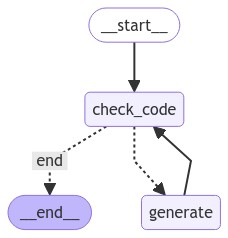

In [23]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Test Graph

In [24]:
_printed = set()
thread_id = str(uuid.uuid4())

question = code_question.format(description=input_problem_description,
                                self_reflection=reflection_output.self_reflection,
                                s_best_solution=format_best_ranked_solution(rs_output),
                                format_instructions=cg_parser.get_format_instructions()
                                )

for i, problem_test in enumerate(reflection_output.tests_explanations):
    print("*" * 20)
    print(f"Test case {i + 1}")
    print("*" * 20)
    config = {
        "configurable": {
            "thread_id": f"thread_id_{i + 1}",  # Checkpoints are accessed by thread_id
        }
    }

    events = graph.stream(
        {"messages": [
            ("user", question),
            (
                "assistant",
                f"Prefix:\n{cg_output.prefix} \nImports:\n{cg_output.imports} \nCode:\n{cg_output.code}",
            )
        ],
            "generation": cg_output,
            "problem_input_output": problem_test,
            "iterations": 0
        }
        , config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

    if event['error'] == "no":  # Solution was either working or after update its working
        print("Code is correct. Updating code solution.")
        cg_output: CodeGenerationParser = event['generation']  # Updating working code
    else:
        print("Failed to generate code. Skipping code update.")

********************
Test case 1
********************
================================ Human Message =================================


You are given a code contest problem, and a self-reflection ... (truncated)
================================== Ai Message ==================================

Prefix:
The problem involves building a circular amusement p ... (truncated)
Checking code solution...
Executing code with provided input and capturing output...
Code executed successfully without any errors.
Decision: Finish
Code is correct. Updating code solution.
********************
Test case 2
********************
================================ Human Message =================================


You are given a code contest problem, and a self-reflection ... (truncated)
================================== Ai Message ==================================

Prefix:
The problem involves building a circular amusement p ... (truncated)
Checking code solution...
Executing code with provided input and c

## Final Generated Code

In [26]:
final_code = f"{cg_output.imports}\n{cg_output.code}"
print(final_code)

import sys
import math
from heapq import nsmallest

def read_input():
    input = sys.stdin.read()
    data = input.split()
    n = int(data[0])
    k = int(data[1])
    coordinates = [(int(data[i * 2 + 2]), int(data[i * 2 + 3])) for i in range(n)]
    return n, k, coordinates

def calculate_distances(coordinates):
    return [math.sqrt(x**2 + y**2) for x, y in coordinates]

def find_kth_smallest_distance(distances, k):
    return nsmallest(k, distances)[-1]

def main():
    n, k, coordinates = read_input()
    distances = calculate_distances(coordinates)
    min_radius = find_kth_smallest_distance(distances, k)
    print(f"{min_radius:.10f}")

if __name__ == "__main__":
    main()
